___
<a href='https://towardsdatascience.com/rlcard-building-your-own-poker-ai-in-3-steps-398aa864a0db'> <img src='https://miro.medium.com/max/1000/1*_9abDpNTM9Cbsd2HEXYm9Q.png' width=500 /></a>
___
# Example for no-limit Texas Holdem in R

### Let's train our first Texas Holdem in R!

## > Install packages
To begin with, we install `reticulate`, a package that embeds the Python session within the R session. Specifically, in our tutorial, the `reticulate` is used for virtual environment creation and Python packages connection. Then, we install the package `imager` for the curve plotting of the training performance.

In [1]:
install.packages("reticulate")
library(reticulate)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("imager")
library(imager)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




## > Virtual Environment
Now we create a virtual environment called "r-rlcard"


In [3]:
virtualenv_create('r-rlcard')

virtualenv: r-rlcard


Before using the virtual environment `r-rlcard`, let's double-check if it exists.

In [4]:
virtualenv_list()
use_virtualenv('r-rlcard', required=TRUE)

[1] "r-rlcard"

## >  Import packages
First, we use `py_install()` to install `Rlcard` and `Tensorflow` in R. We recommend to use `'pip = TURE'` for installation because the default conda install method may occur issues.

In [5]:
py_install('rlcard', pip=TRUE)
py_install('rlcard[tensorflow]', pip=TRUE)

Using virtual environment '/Users/miawan/.virtualenvs/r-rlcard' ...
Using virtual environment '/Users/miawan/.virtualenvs/r-rlcard' ...


Then, we import the installed packages and check if the `TensorFlow` version agrees with our needs.

In [6]:
rlcard <- import('rlcard')
tf <- import('tensorflow')
os <- import('os')

In [7]:
tf$"__version__"

[1] "1.14.0"

## > Deep-Q Agent model setup

First, we import the modules that are warped up in rlcard packages. Then, we set the iterations numbers, the initial memory size and how frequently we evaluate the performance. Remember to have `L` to keep the datatype. Finally, we save the performance data and learning curves to our current path as `./log`. 

In [8]:
# Import the modules.
DQNAgent <- rlcard$agents$DQNAgent
RandomAgent <- rlcard$agents$RandomAgent
set_global_seed <- rlcard$utils$set_global_seed
tournament <- rlcard$utils$tournament
Logger <- rlcard$utils$Logger

In [9]:
env = rlcard$make('no-limit-holdem')
eval_env = rlcard$make('no-limit-holdem')

# Set the iterations numbers and how frequently we evaluate the performance.
evaluate_every = 100L
evaluate_num = 1000L
episode_num = 10000L

# Set the intial memory size.
memory_init_size = 1000L

# Train the agent every X steps.
train_every = 1

# Set the paths for saving the logs and learning curves. We save it on our current path.
log_dir = './log'

Before starting the training process, we initial a global step and set up the DQN agents. The Logger is used to plot the learning curve and save it to the same directory as we set up for log.

In [10]:
# Set a global seed.
set_global_seed(0L)
sess <- tf$Session()

# Initialize a global step.
global_step = tf$Variable(0L, name='global_step', trainable=F)

In [11]:
# Set up the DQN agents.
agent = DQNAgent(
  sess,
  scope='dqn',
  action_num=env$action_num,
  replay_memory_init_size = memory_init_size,
  train_every=train_every,
  state_shape=env$state_shape,
  mlp_layers=c(512, 512)
)

random_agent = RandomAgent(action_num=eval_env$action_num)
env$set_agents(list(agent, random_agent))
eval_env$set_agents(list(agent, random_agent))

In [12]:
# Initialize global variables and a Logger to plot the learning curve.
sess$run(tf$global_variables_initializer())
logger = Logger(log_dir)

## > Train the model


Training the model requires complicated interactions with Tensorflow. Thus, we recommend importing a Python script. Specifically, we create a file named `train.py` in the same directory with content as follows.


    def train(episode_num, env, eval_env, evaluate_every, evaluate_num, agent, logger, tournament):
       for episode in range(episode_num):
     
         # Generate data from the environment
         trajectories, _ = env.run(is_training = True)

         # Feed transitions into agent memory, and train the agent
         for ts in trajectories[0]:
             agent.feed(ts)

         # Evaluate the performance. Play with random agents.
         if episode % evaluate_every == 0:
             logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

Now we use the `train.py` to train the model

In [13]:
reticulate::source_python("train.py")
train(episode_num, env, eval_env, evaluate_every, evaluate_num, agent, logger, tournament)

Close files in the logger and Plot the learning curve in our file.

In [14]:
logger$close_files()
logger$plot('DQN')

Let's display our training performace and the plot.

In [15]:
txt <- read.csv(file='./log/performance.csv')
txt

timestep reward
1      2     -1.460
2    292     -1.094
3    601      3.662
4    900      1.044
5   1202     -0.327
6   1510      0.756
7   1787     -1.239
8   2070      0.845
9   2349      1.522
10  2612      2.443
11  2906      4.467
12  3187      2.209
13  3473      0.879
14  3744      3.432
15  3988      2.140
16  4262      3.043
17  4570      4.603
18  4898      2.461
19  5182      3.734
20  5476      4.951
21  5779      2.313
22  6063      3.474
23  6351      2.699
24  6660      1.004
25  6926      0.085
26  7213      5.468
27  7511      2.067
28  7791      3.510
29  8091      0.908
30  8381      3.949
⋮   ⋮        ⋮     
71  21020    6.005 
72  21318    6.859 
73  21625    8.444 
74  21959    3.461 
75  22313    6.780 
76  22662    0.070 
77  22971    4.600 
78  23289    6.932 
79  23606    5.139 
80  23932    3.247 
81  24268    6.953 
82  24604    8.206 
83  24978    9.084 
84  25330    2.868 
85  25657    5.358 
86  25981    4.339 
87  26315    5.083 
88  26655    4.674 
89  27031    1.920 
90  27444    1.565 
91  27772    9.555 
92  28105    8.529 
93  28448    3.337 
94  28801    3.808 
95  29122    6.176 
96  29464    6.588 
97  29801    5.516 
98  30153    8.830 
99  30508    4.533 
100 30877    5.664

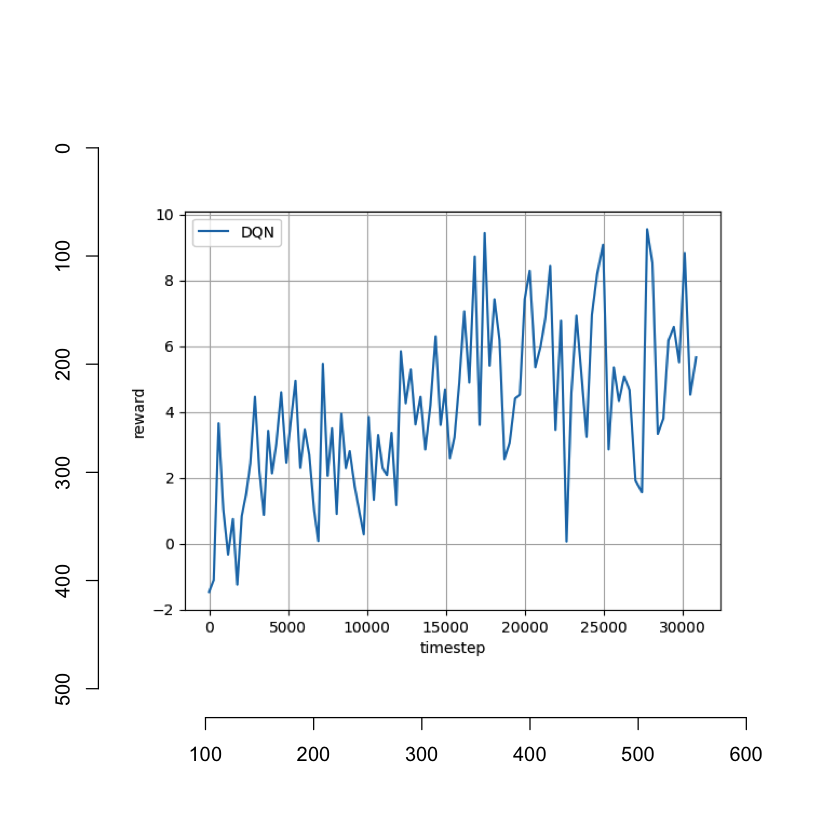

In [16]:
library(imager)
load.image("~/Desktop/log/fig.png") %>% plot

In the end, we save the trained model to `models/leduc_holdem_nfsp` .

In [17]:
save_dir = 'models/leduc_holdem_nfsp'
if (!dir.exists(save_dir)){
    os$makedirs(save_dir)}
saver = tf$train$Saver()
saver$save(sess, os$path$join(save_dir, 'model'))

[1] "models/leduc_holdem_nfsp/model"

### Now you have your no-limit Texas Holdem model.
## Good Job!

___